<a href="https://colab.research.google.com/github/urvi1703/Project/blob/master/Data_Science_Intern_Assignment_Algorithmic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance ta matplotlib seaborn scikit-learn xgboost
!pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c17c034926d353081ee15cb43522b2b54229a6d510ccd7f618eb1a8c3e545a17
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


<ipython-input-29-014abefedb84>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


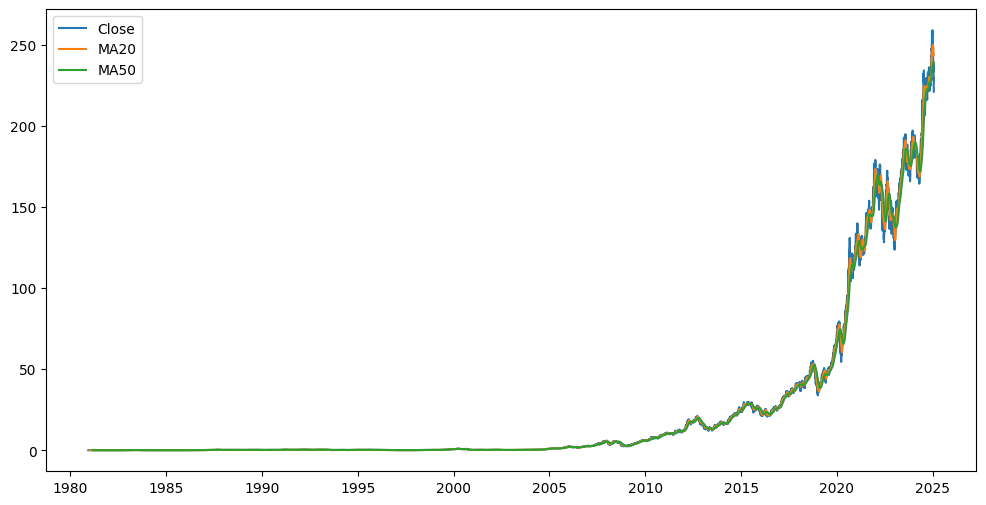

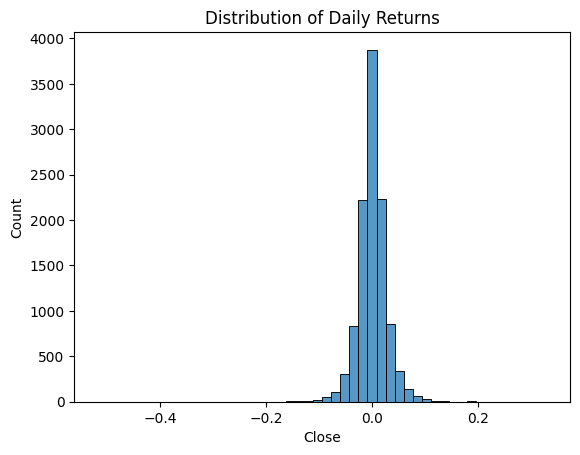

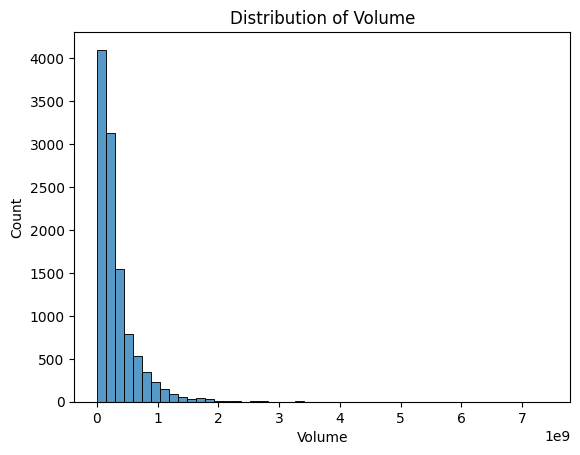

ValueError: Found input variables with inconsistent numbers of samples: [11068, 11117]

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# --- Data Acquisition ---
tickerSymbol = 'AAPL'  # Replace with the desired stock symbol
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period='max')

if df.empty:
    print(f"Error: DataFrame is empty. Check yfinance data retrieval for {tickerSymbol}.")
    exit()

# --- Data Preprocessing ---
df = df.fillna(method='ffill')

# --- Feature Engineering ---
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

def RSI(data, period=14):
    delta = data.diff().dropna()
    up = delta * 0
    down = delta * 0
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]
    avg_gain = up.rolling(window=period).mean()
    avg_loss = down.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1 + rs))
    return rsi

df['RSI'] = RSI(df['Close'])

# Calculate MACD
short_ema = df['Close'].ewm(span=12, adjust=False).mean()
long_ema = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['Volume_Change'] = df['Volume'].pct_change()

# --- Data Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA50'], label='MA50')
plt.legend()
plt.show()

sns.histplot(df['Close'].pct_change().dropna(), bins=50)
plt.title('Distribution of Daily Returns')
plt.show()

sns.histplot(df['Volume'], bins=50)
plt.title('Distribution of Volume')
plt.show()

# --- Prepare data for modeling ---
df['Target'] = df['Close'].shift(-1) > df['Close']
df['Target'] = df['Target'].astype(int)

features = ['Close', 'MA20', 'MA50', 'RSI', 'MACD', 'Volume', 'Volume_Change']
X = df[features].dropna()
y = df['Target'].dropna()

# Check for empty data before splitting
if len(y) == 0:
    print("Error: No data available for training.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train and evaluate models ---
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("XGBoost:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# --- Backtesting ---
initial_capital = 10000
position = 0  # 0: no position, 1: long, -1: short
portfolio = [initial_capital]
transaction_cost = 0.001  # 0.1% transaction cost

for i in range(len(X_test)):
    pred = model.predict(X_test.iloc[i:i+1, :])
    if pred[0] == 1 and position != 1:
        position = 1
        portfolio.append(portfolio[-1] * (1 + df['Close'].iloc[i+1] / df['Close'].iloc[i] - transaction_cost))
    elif pred[0] == 0 and position == 1:
        position = 0
        portfolio.append(portfolio[-1] * (1 - transaction_cost))
    elif pred[0] == 0 and position != 0:
        position = 0
        portfolio.append(portfolio[-1])
    else:
        portfolio.append(portfolio[-1])

plt.figure(figsize=(12, 6))
plt.plot(portfolio, label='Backtest')
plt.plot(df['Close'].iloc[len(df) - len(X_test):], label='Buy and Hold')
plt.legend()
plt.title('Backtest vs. Buy and Hold')
plt.show()

# Calculate performance metrics
cumulative_returns = (portfolio[-1] / initial_capital) - 1
print('Cumulative Returns:', cumulative_returns)
# Implement Sharpe Ratio calculation (requires risk-free rate)

In [ ]:
print(len(X), len(y))

11068 11117


In [ ]:
print(X.isnull().sum())
print(y.isnull().sum())

Close            0
MA20             0
MA50             0
RSI              0
MACD             0
Volume           0
Volume_Change    0
dtype: int64
0


In [ ]:
df['Target'] = df['Close'].shift(-1) > df['Close']
df = df.iloc[:-1, :]  # Drop the last row

In [ ]:
df['Target'] = df['Close'].shift(-1) > df['Close']
df['Target'].fillna(method='ffill', inplace=True)

<ipython-input-33-cac8597d6758>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Target'].fillna(method='ffill', inplace=True)
<ipython-input-33-cac8597d6758>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Target'].fillna(method='ffill', inplace=True)


In [ ]:
features = ['Close', 'MA20', 'MA50', 'RSI', 'MACD', 'Volume', 'Volume_Change']
X = df[features]
y = df['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-3-131c7826937e>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


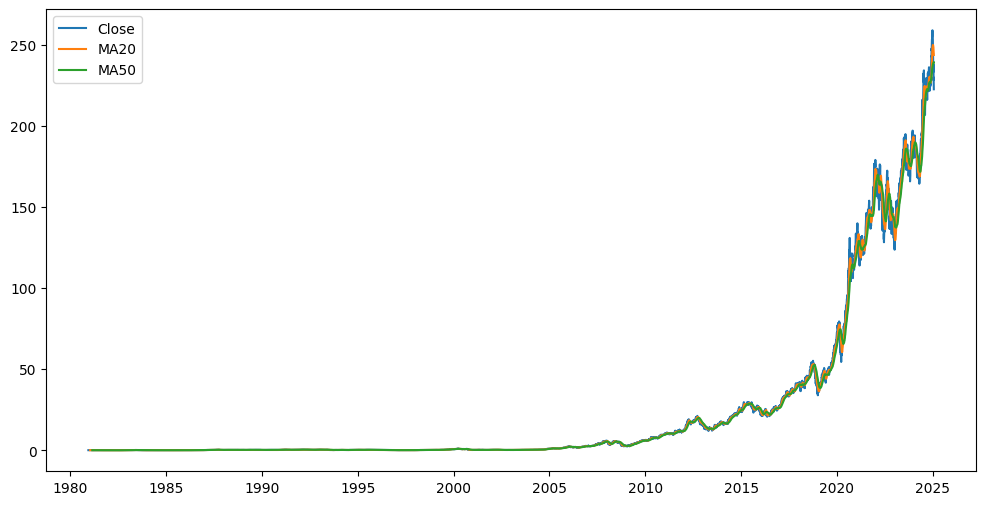

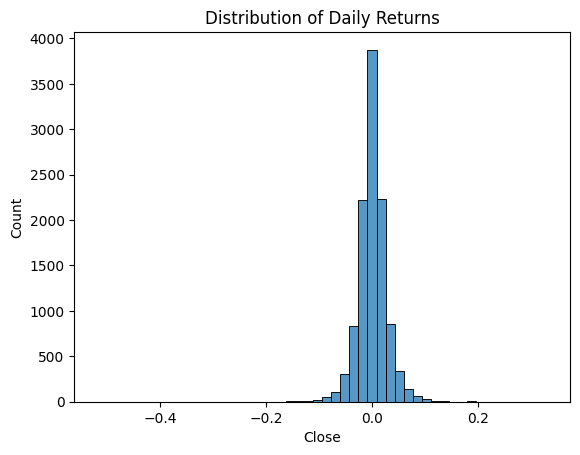

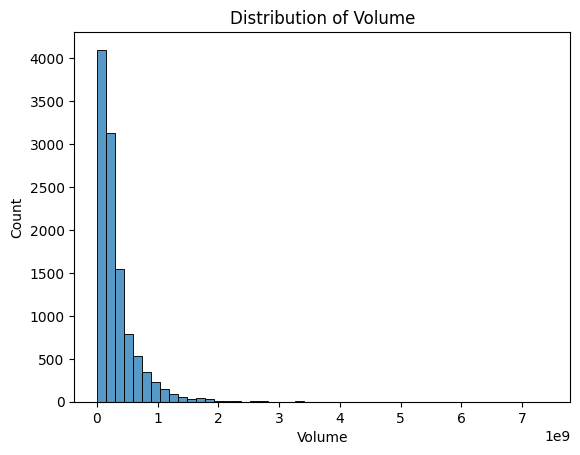

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Data Acquisition ---
tickerSymbol = 'AAPL'  # Replace with the desired stock symbol
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period='max')

if df.empty:
    print(f"Error: DataFrame is empty. Check yfinance data retrieval for {tickerSymbol}.")
    exit()

# --- Data Preprocessing ---
df = df.fillna(method='ffill')

# --- Feature Engineering ---
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

def RSI(data, period=14):
    delta = data.diff().dropna()
    up = delta * 0
    down = delta * 0
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]
    avg_gain = up.rolling(window=period).mean()
    avg_loss = down.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1 + rs))
    return rsi

df['RSI'] = RSI(df['Close'])

# Calculate MACD
short_ema = df['Close'].ewm(span=12, adjust=False).mean()
long_ema = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['Volume_Change'] = df['Volume'].pct_change()

# --- Data Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA50'], label='MA50')
plt.legend()
plt.show()

sns.histplot(df['Close'].pct_change().dropna(), bins=50)
plt.title('Distribution of Daily Returns')
plt.show()

sns.histplot(df['Volume'], bins=50)
plt.title('Distribution of Volume')
plt.show()

# --- Prepare data for modeling ---
df['Target'] = df['Close'].shift(-1) > df['Close']
df['Target'] = df['Target'].astype(int)
df = df.dropna()  # Drop rows with missing values after creating 'Target'

features = ['Close', 'MA20', 'MA50', 'RSI', 'MACD', 'Volume', 'Volume_Change']
X = df[features]
y = df['Target']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Handle Missing Values (if any) ---
# Uncomment and choose one of the following:

# 1. Imputation (e.g., Mean Imputation)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)
# X_train = X_train_imputed
# X_test = X_test_imputed

# 2. Drop Rows with Missing Values
# X_train = X_train.dropna()
# y_train = y_train[X_train.index]  # Ensure y_train has the same indices as X_train

# --- Train and evaluate models ---
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("XGBoost:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))
print()

# --- Backtesting ---
initial_capital = 10000
position = 0  # 0: no position, 1: long, -1: short
portfolio = [initial_capital]
transaction_cost = 0.001  # 0.1% transaction cost

for i in range(len(X_test)):
    pred = model.predict(X_test.iloc[i:i+1, :])
    if pred[0] == 1 and position != 1:
        position = 1
        portfolio.append(portfolio[-1] * (1 + df['Close'].iloc[i+1] / df['Close'].iloc[i] - transaction_cost))
    elif pred[0] == 0 and position == 1:
        position = 0
        portfolio.append(portfolio[-1] * (1 - transaction_cost))
    elif pred[0] == 0 and position != 0:
        position = 0
        portfolio.append(portfolio[-1])
    else:
        portfolio.append(portfolio[-1])

plt.figure(figsize=(12, 6))
plt.plot(portfolio, label='Backtest')
plt.plot(df['Close'].iloc[len(df) - len(X_test):], label='Buy and Hold')
plt.legend()
plt.title('Backtest vs. Buy and Hold')
plt.show()

# Calculate performance metrics
cumulative_returns = (portfolio[-1] / initial_capital) - 1
print('Cumulative Returns:', cumulative_returns)
# Implement Sharpe Ratio calculation (requires risk-free rate)